In [1]:
# DDPM: slow + step by step
# DDIM: next version of DDPM , fewer + high q.
# LDM: less q. + faster
# SDXL: fast + high q. + detail(original content)


# # | Library          | Purpose                                                            |
# # | ---------------- | ------------------------------------------------------------------ |
# # | **diffusers**    | Runs Stable Diffusion, Flux, and other image models                |
# # | **transformers** | Handles tokenizers/LLMs used for prompts                           |
# # | **accelerate**   | Optimizes GPU usage & fast inference                               |
# # | **safetensors**  | Loads model weights safely & fast                                  |
# # | **xformers**     | Provides *memory-efficient attention* → speeds up image generation |



In [2]:
# --- CELL 1: Install dependencies (compatible versions) ---
print("Installing compatible dependencies...")

!pip install -q --upgrade pip
!pip install -q "torch>=2.2" torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install -q --upgrade diffusers transformers accelerate safetensors xformers
!pip install -q "pillow<12.0" opencv-python matplotlib

print("✅ All packages installed. Restart the runtime before continuing.")


Installing compatible dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.9.0+cu126 requires torch==2.9.0, but you have torch 2.9.1 which is incompatible.
torchvision 0.24.0+cu126 requires torch==2.9.0, but you have torch 2.9.1 which is incompatible.
✅ All packages installed. Restart the runtime before continuing.


In [3]:
# --- CELL 2: Unified one-file script for caching & generation ---
# Imports
import os
import time
import gc
import torch
from PIL import Image
from IPython.display import display, HTML

# Prefer float16 where possible
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionXLPipeline,
    DDIMScheduler
)


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [4]:
# -------------------------
# Configuration : to store all the cache and to be accessed and deleted using the path
# to give instruction that we are using T4 Gpu not the default processing unit.
# -------------------------
cache_dir = "/content/huggingface_cache"
os.makedirs(cache_dir, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
print(f"Model cache directory: {cache_dir}")


Device: cuda
Model cache directory: /content/huggingface_cache


In [5]:
# Optional: if you have a Hugging Face token and want to use it (not required for many public models)
# os.environ["HF_TOKEN"] = "hf_your_token_here"  # <--- only if you have one

# Random seed generator configured for correct device
generator = None
if device == "cuda":
    generator = torch.Generator(device="cuda").manual_seed(42)
else:
    generator = torch.Generator(device="cpu").manual_seed(42)


In [15]:
# Example Prompts
#"A young woman with curly hair, sitting on a park bench, golden hour lighting, photorealistic, 8k, highly detailed, cinematic"
# "A futuristic smartphone on a reflective glass table, studio lighting, ultra-realistic, 4k render, sharp details"
#"A majestic dragon flying over snowy mountains, dramatic clouds, cinematic lighting, concept art, digital painting"

prompt_sd1_5 = "A breathtaking night ocean scene with a large full moon glowing in the sky, moonlight reflecting across gentle ocean waves, glowing blue bioluminescent plankton illuminating the water near the shore, soft ripples sparkling with neon blue light, dark horizon blending into a star-filled sky, thin clouds drifting past the moon, magical yet realistic atmosphere, cinematic lighting, ultra-detailed, photorealistic, 4K resolution"
prompt_sdxl = "A breathtaking night ocean scene with a large full moon glowing in the sky, moonlight reflecting across gentle ocean waves, glowing blue bioluminescent plankton illuminating the water near the shore, soft ripples sparkling with neon blue light, dark horizon blending into a star-filled sky, thin clouds drifting past the moon, magical yet realistic atmosphere, cinematic lighting, ultra-detailed, photorealistic, 4K resolution"


# prompt_sd1_5 = input("write your prompt")
# prompt_sdxl = input ("write your 2nd prompt")

In [16]:
# Utility: reduce GPU memory pressure
def free_cuda_cache():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [17]:
# -------------------------
# Helper to safely load a StableDiffusionPipeline
# -------------------------
def safe_from_pretrained(cls_name, repo_id, **kwargs):
    """
    Tries to load a pipeline and if the safety checker init causes a TypeError
    (or similar), retries with safety_checker=None.
    """
    try:
        pipe = cls_name.from_pretrained(repo_id, **kwargs)
        return pipe
    except TypeError as e:
        print(f"TypeError during loading {repo_id}: {e}")
        print("Retrying with safety_checker=None and requires_safety_checker=False ...")
        kwargs["safety_checker"] = None
        kwargs["requires_safety_checker"] = False
        pipe = cls_name.from_pretrained(repo_id, **kwargs)
        return pipe
    except Exception as e:
        print(f"Failed to load {repo_id}: {e}")
        raise

In [18]:
# -------------------------
# 1) Cache / download models (one-time)
# -------------------------
print("\n=== Step 1: Caching / Downloading models to local cache_dir ===")
free_cuda_cache()

t0 = time.time()
print("Downloading (caching) runwayml/stable-diffusion-v1-5 ...")
# We download to the cache directory but we don't move to GPU yet.
try:
    # Use dtype arg (diffusers accepts dtype)
    StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        cache_dir=cache_dir,
        safety_checker=None,              # prevent safety-checker init errors during caching
        requires_safety_checker=False
    )
    print("Cached SD 1.5.")
except Exception as e:
    print("Warning: caching SD 1.5 failed:", e)
print(f"Caching step done in {time.time()-t0:.1f}s (may have been partial).")


=== Step 1: Caching / Downloading models to local cache_dir ===


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Cached SD 1.5.
Caching step done in 15.0s (may have been partial).


In [19]:
print("\nDownloading (caching) stabilityai/stable-diffusion-xl-base-1.0 (this is large) ...")
try:
    StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        torch_dtype=torch.float16,
        variant="fp16",
        use_safetensors=True,
        cache_dir=cache_dir,
        safety_checker=None,
        requires_safety_checker=False
    )
    print("Cached SDXL base.")
except Exception as e:
    print("Warning: caching SDXL failed (this may be due to network/auth or model size):", e)

print(f"Caching step done in {time.time()-t0:.1f}s (may have been partial).")


Keyword arguments {'safety_checker': None, 'requires_safety_checker': False} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Cached SDXL base.
Caching step done in 26.5s (may have been partial).


In [20]:
# -------------------------
# 2) Load SD1.5 and generate (local cached)
# -------------------------
print("\n=== Step 2: Load SD1.5 from cache and generate ===")
free_cuda_cache()

try:
    pipe_sd1_5 = safe_from_pretrained(
        StableDiffusionPipeline,
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        cache_dir=cache_dir
    )
    # Move to device
    pipe_sd1_5 = pipe_sd1_5.to(device)
    # Save VRAM with attention slicing (works for most pipelines)
    try:
        pipe_sd1_5.enable_attention_slicing() #Reduces GPU memory usage by computing attention in smaller “slices” instead of all at once.
    except Exception:
        pass
    # Also enable xformers if available for memory-efficient attention (optional)
    try:
        pipe_sd1_5.enable_xformers_memory_efficient_attention() #Uses xFormers library to make attention computation more efficient and reduce VRAM
    except Exception:
        pass

    print("SD 1.5 loaded on", device)

    # Generate three variants
    print("Generating SD1.5 images...")
    free_cuda_cache()
    image_ddpm = pipe_sd1_5(prompt_sd1_5, num_inference_steps=25, generator=generator).images[0]
    image_ldm  =  pipe_sd1_5(prompt_sd1_5, num_inference_steps=20, guidance_scale=7.5, generator=generator).images[0] #guidance_scale=7.5 → Controls classifier-free guidance strength (how strongly model follows prompt).
    # change scheduler to DDIM and generate
    pipe_sd1_5.scheduler = DDIMScheduler.from_config(pipe_sd1_5.scheduler.config)
    image_ddim = pipe_sd1_5(prompt_sd1_5, num_inference_steps=20, generator=generator).images[0]
    print("SD1.5 generation done.")
except Exception as e:
    print("SD1.5 failed to load or generate:", e)
    image_ddpm = image_ldm = image_ddim = None




=== Step 2: Load SD1.5 from cache and generate ===


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (83 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['photorealistic , 4 k resolution']


SD 1.5 loaded on cuda
Generating SD1.5 images...


  0%|          | 0/25 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['photorealistic , 4 k resolution']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['photorealistic , 4 k resolution']


  0%|          | 0/20 [00:00<?, ?it/s]

SD1.5 generation done.


In [21]:
# -------------------------
# 3) Try to load SDXL and generate (optional; may fail on small GPUs)
# -------------------------
print("\n=== Step 3: Attempt to load SDXL (may fail on Colab Free GPU) ===")
free_cuda_cache()
image_sdxl = None
try:
    sdxl_pipe = safe_from_pretrained(
        StableDiffusionXLPipeline,
        "stabilityai/stable-diffusion-xl-base-1.0",
        torch_dtype=torch.float16,
        variant="fp16",
        use_safetensors=True,
        cache_dir=cache_dir
    )
    # Move to device (this may OOM)
    sdxl_pipe = sdxl_pipe.to(device)
    # Reduce memory usage where possible
    try:
        sdxl_pipe.enable_attention_slicing()
    except Exception:
        pass
    try:
        sdxl_pipe.enable_xformers_memory_efficient_attention()
    except Exception:
        pass

    print("SDXL loaded on", device)
    print("Generating SDXL image (this may take a while)...")
    free_cuda_cache()
    image_sdxl = sdxl_pipe(prompt_sdxl, num_inference_steps=25, guidance_scale=8.0, generator=generator).images[0]
    print("SDXL generation done.")
except Exception as e:
    print("SDXL failed to load or generate (expected on low-VRAM GPUs). Error:", e)
    image_sdxl = None



=== Step 3: Attempt to load SDXL (may fail on Colab Free GPU) ===


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (83 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['photorealistic, 4 k resolution']
Token indices sequence length is longer than the specified maximum sequence length for this model (83 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['photorealistic, 4 k resolution']


SDXL loaded on cuda
Generating SDXL image (this may take a while)...


  0%|          | 0/25 [00:00<?, ?it/s]

SDXL generation done.



=== Results ===

SD1.5 - ddpm result


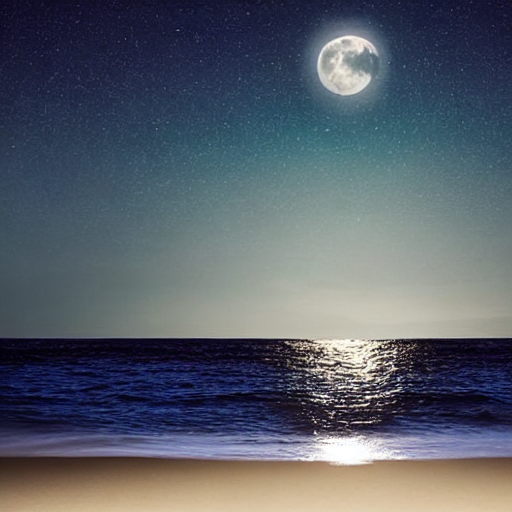


SD1.5 - ldm result


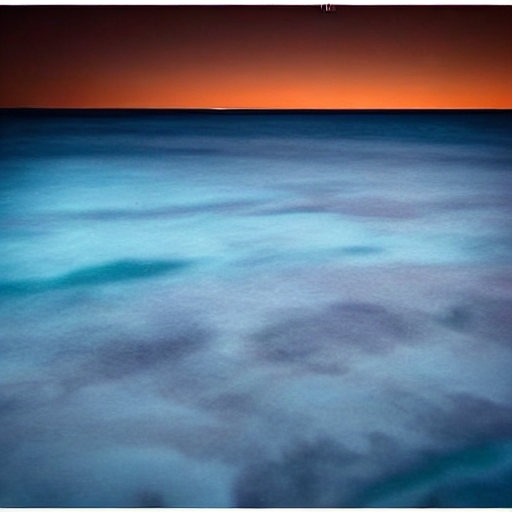


SD1.5 - ddim result


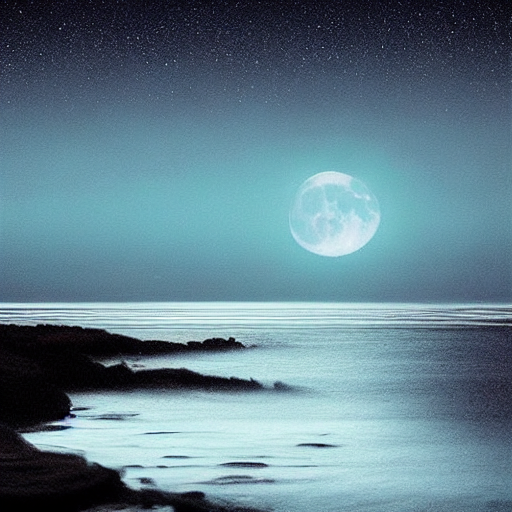


SDXL result


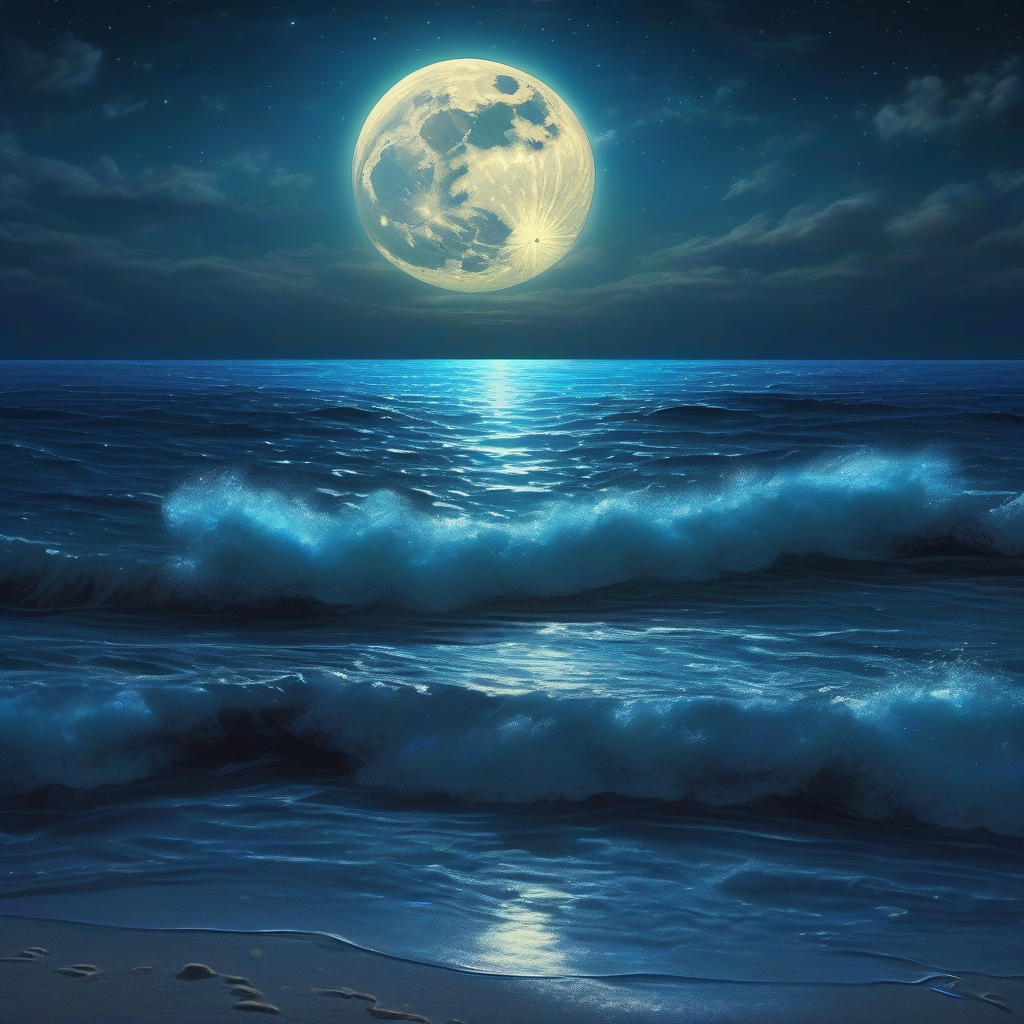


All done. If SDXL failed due to OOM, try again on a higher-VRAM runtime (Colab Pro / GPU runtime with more memory) or skip SDXL.


In [22]:
# -------------------------
# 4) Display results (only those generated)
# -------------------------
print("\n=== Results ===")
if image_ddpm:
    print("\nSD1.5 - ddpm result")
    display(image_ddpm)
if image_ldm:
    print("\nSD1.5 - ldm result")
    display(image_ldm)
if image_ddim:
    print("\nSD1.5 - ddim result")
    display(image_ddim)
if image_sdxl:
    print("\nSDXL result")
    display(image_sdxl)

print("\nAll done. If SDXL failed due to OOM, try again on a higher-VRAM runtime (Colab Pro / GPU runtime with more memory) or skip SDXL.")
